In [1]:
from halos import Catalog, Cosmo
from astropy.cosmology import LambdaCDM, z_at_value
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import astropy.units as u
from scipy.interpolate import make_interp_spline

h_Hubble = 0.67

%matplotlib inline

## Redshift computation

One of the most computationally expensive operations is the calculation of the halo redshift given the comoving distance. This calculation can be performed using the `z_at_value` function from Astropy, with the cosmological parameters correctly set. By analyzing the information from the shells, which provide both the redshift and the comoving distance at the start and end of the shells, it was observed that when setting the cosmological parameters to match the simulation values, and using the `z_at_value` function or calculating the redshift independently, a discrepancy arises between the values obtained from the simulation and those calculated. Therefore, it was decided to correct the values calculated with `z_at_value` by applying a correction factor, which depends on the redshift. The correction factor is obtained through a cubic spline interpolation of the known points from the shells.




In [2]:
cosmo = Cosmo()
D = np.concatenate((cosmo.data['distance'], cosmo.data['xend']))
red = np.concatenate((cosmo.data['z'], cosmo.data['zend']))

# Ordinamento
sorted_indices = np.argsort(red)
z_sorted = red[sorted_indices]
distance_sorted = D[sorted_indices]

# Rimuovere duplicati
unique_z, unique_indices = np.unique(z_sorted, return_index=True)
unique_distance = distance_sorted[unique_indices]

# spline
distance2redshift = make_interp_spline(unique_distance, unique_z, k = 3)
correction = make_interp_spline(cosmo.data['z'][1:], cosmo.data['z_correction'][1:], k = 3)

# Creazione dati
z_values = np.linspace(0, 100, 500)
d_values = np.linspace(1e4, 8.6e6, 1000)

/opt/miniconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2972: RuntimeWarning: overflow encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


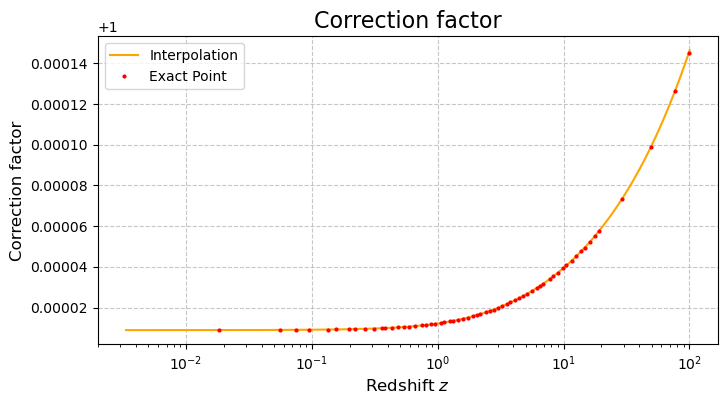

In [3]:
redshift = z_at_value(cosmo.cosmo.comoving_distance, d_values * u.kpc / h_Hubble, zmin = 0, zmax = 5000)

plt.figure(figsize=(8,4))
plt.plot(redshift, correction(redshift), color="orange", label="Interpolation")
plt.plot(cosmo.data['z'][1:], cosmo.data['z_correction'][1:], marker="o", markersize=2, linestyle="None", color="red", label="Exact Point")
plt.title("Correction factor", fontsize=16)
plt.xlabel(f"Redshift $z$", fontsize = 12)
plt.ylabel(f"Correction factor", fontsize = 12)
plt.xscale("log")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


The curve obtained from `z_at_value` multiplied by the correction factor was then considered the exact theoretical curve. However, this method for calculating the redshift given the comoving distance is not suitable for processing a large number of halos. For this reason, spline interpolation was also used to calculate the redshift from the comoving distance. In the graph below, it is shown that the error introduced by this approximation is always smaller than $0.2\%$.

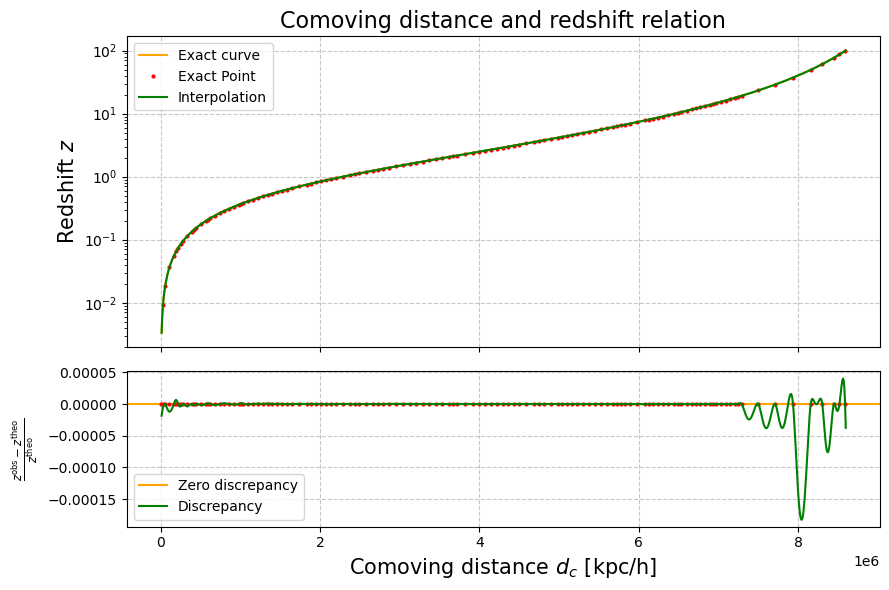

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Primo grafico: Redshift vs Comoving distance
ax1.plot(d_values, redshift * correction(redshift), color="orange", label="Exact curve")
ax1.plot(unique_distance, unique_z, marker="o", markersize=2, linestyle="None", color="red", label="Exact Point")
ax1.plot(d_values, distance2redshift(d_values), linestyle="-", color="green", label="Interpolation")
ax1.set_ylabel('Redshift $z$', fontsize=15)
ax1.set_yscale('log')

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=10)
ax1.set_title('Comoving distance and redshift relation', fontsize=16)

# Secondo grafico: Discrepanza relativa
discrepancy = (distance2redshift(d_values) - (redshift * correction(redshift))) / (redshift * correction(redshift))

ax2.axhline(0, color='orange', linestyle='-', label='Zero discrepancy')
ax2.plot(unique_distance, np.zeros_like(unique_distance), linestyle='None', color="red", marker="o", markersize=2)
ax2.plot(d_values, discrepancy, linestyle='-', color='green', label='Discrepancy')
ax2.set_xlabel('Comoving distance $d_c$ [kpc/h]', fontsize=15)
ax2.set_ylabel(r'$\frac{z^{\rm obs} - z^{\rm theo}}{z^{\rm theo}}$', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=10)

# Adattamento layout
plt.tight_layout()
plt.show()


## Halos

I create two plots showing the distribution of halos in shells. The first plot is a 3D plot showing the spatial positions, while the second one ignores the azimuthal coordinate to better show that the halos lie within two concentric shells.

In [5]:
snapshot_number = 60
mass_inf = 1e3

In [6]:
info = Cosmo()
catalog = Catalog(snapshot_number)

print(f"Numer of halos: {catalog.get_n_halos()}")
catalog_selection = catalog.select_mass_above(mass_inf)
print(f"Number of halos (M>1e3): {catalog_selection.get_n_halos()}")
del catalog
catalog_selection.compute_all()

Reading AllSkyMock_snap_060_0.bin0...
Reading AllSkyMock_snap_060_1.bin0...
Reading AllSkyMock_snap_060_2.bin0...
Reading AllSkyMock_snap_060_3.bin0...
Numer of halos: 45050
Number of halos (M>1e3): 8229
-------------- (np.float64(0.0), 62) --------------
Reading KappaMap_snap_062.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_062.DM.seed_100672.fits... 

-------------- (np.float64(0.01815), 61) --------------
Reading KappaMap_snap_061.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_061.DM.seed_100672.fits... 

-------------- (np.float64(0.05545), 60) --------------
Reading KappaMap_snap_060.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_060.DM.seed_100672.fits... 



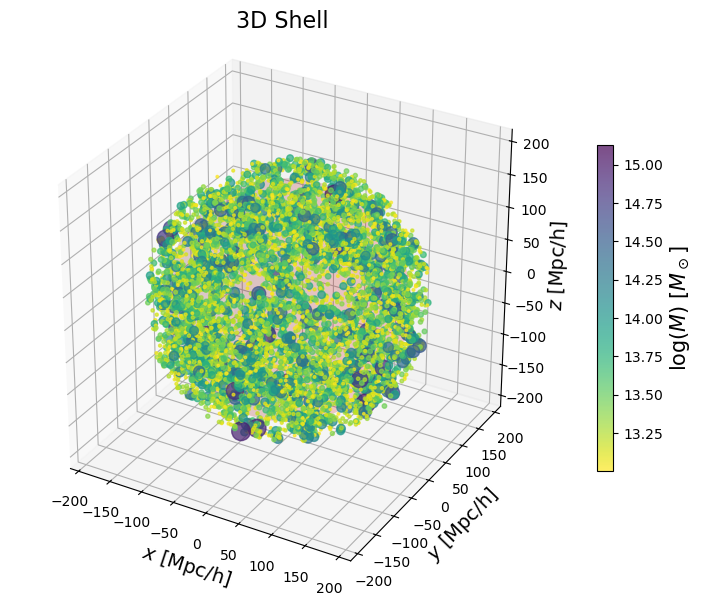

In [7]:
# Definisci il raggio della sfera
raggio = info.from_snapshot_get(snapshot_number, 'distance')/10**3

# Crea gli angoli sferici (theta, phi)
theta = np.linspace(0, 2 * np.pi, 100)  # Angolo azimutale
phi = np.linspace(0, np.pi, 100)        # Angolo zenitale

# Creare una griglia di punti sferici
theta, phi = np.meshgrid(theta, phi)

# Converti le coordinate sferiche in cartesiane
x_sfera = raggio * np.sin(phi) * np.cos(theta)
y_sfera = raggio * np.sin(phi) * np.sin(theta)
z_sfera = raggio * np.cos(phi)

# Crea il plot 3D
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot dei dati degli aloni
sc = ax.scatter(catalog_selection.pos_x/10**3,
                catalog_selection.pos_y/10**3,
                catalog_selection.pos_z/10**3,
                c=10 + np.log10(catalog_selection.mass), 
                cmap='viridis_r', 
                s=0.0005 * np.log10(catalog_selection.mass)**8,
                alpha=0.7)

# Aggiungi una barra colori per rappresentare la massa
cb = plt.colorbar(sc, ax=ax, shrink=0.6)
cb.set_label(rf'$\log(M)$ [$M_\odot$]', fontsize=15)

# Configura gli assi
ax.set_xlabel(r'$x$ [Mpc/h]', fontsize=14)
ax.set_ylabel(r'$y$ [Mpc/h]', fontsize=14)
ax.set_zlabel(r'$z$ [Mpc/h]', fontsize=14)
ax.set_title('3D Shell', fontsize=16)

# Imposta la stessa unità per tutti gli assi (distanza uguale su tutti gli assi)
ax.set_box_aspect([1, 1, 1])  # Impostazione uguale per tutti gli assi

# Traccia la sfera
ax.plot_surface(x_sfera, y_sfera, z_sfera, color='r', alpha=0.1)

# Ottimizzazione della disposizione e degli spazi
plt.tight_layout()

# Mostra il grafico
plt.show()


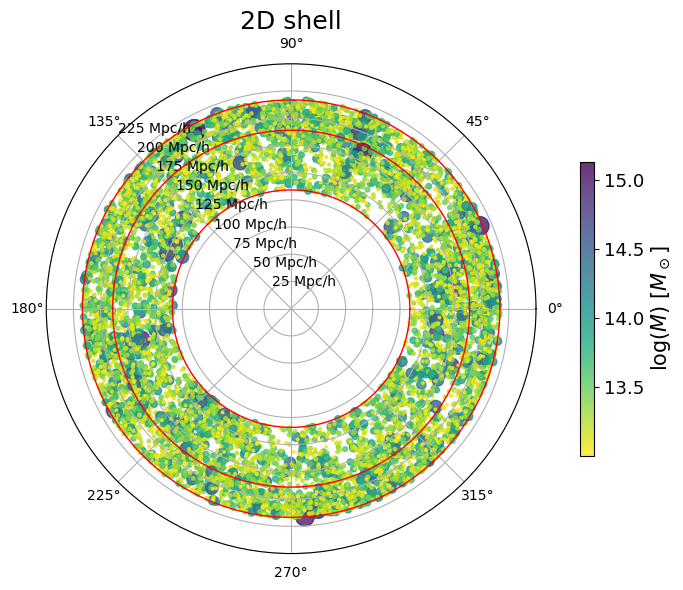

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(9, 6))  # Dimensioni aumentate

# Scatter plot: posizione degli aloni nel piano (distanza vs angolo azimutale)
sc = ax.scatter(catalog_selection.phi, catalog_selection.distance/(10**3), 
                c=10 + np.log10(catalog_selection.mass), 
                cmap='viridis_r', 
                s=0.0005 * np.log10(catalog_selection.mass)**8, 
                alpha=0.8)

# Aggiungi cerchi con raggi specifici
radii = [info.from_snapshot_get(snapshot_number, 'xstart')/(10**3),
         info.from_snapshot_get(snapshot_number, 'distance')/(10**3),
         info.from_snapshot_get(snapshot_number, 'xend')/(10**3)]

for radius in radii:
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.full(100, radius), 
            lw=1, color='red')

# Barra colori
cb = plt.colorbar(sc, ax=ax, shrink=0.6)
cb.set_label(rf'$\log(M)$ [$M_\odot$]', fontsize=15)
cb.ax.tick_params(labelsize=13)

# Configurazione degli assi
ax.set_title('2D shell', fontsize=18)

# Modifica dei label per coordinate polari
ax.set_rlabel_position(135)


ax.set_rticks([25, 50, 75, 100, 125, 150, 175, 200, 225])
ax.set_yticklabels([f"{r} Mpc/h" for r in [25, 50, 75, 100, 125, 150, 175, 200, 225]])


plt.tight_layout()
plt.show()


Now I use the known data to calculate the luminosity distance corrected according to Bertacca and create two Mollview plots.

In [9]:
snapshot_number = 40
mass_inf = 1e3
n_side = 4096
n_pix = hp.nside2npix(n_side)

catalog = Catalog(snapshot_number)
print(f"Numer of halos: {catalog.get_n_halos()}")
catalog_selection = catalog.select_mass_above(mass_inf)
print(f"Number of halos (M>1e3): {catalog_selection.get_n_halos()} \n")
del catalog
catalog_selection.compute_all(n_side=n_side)

/opt/miniconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2972: RuntimeWarning: overflow encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


Reading AllSkyMock_snap_040_0.bin0...
Reading AllSkyMock_snap_040_1.bin0...
Reading AllSkyMock_snap_040_2.bin0...
Reading AllSkyMock_snap_040_3.bin0...
Numer of halos: 14517825
Number of halos (M>1e3): 1958848 

-------------- (np.float64(0.0), 62) --------------
Reading KappaMap_snap_062.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_062.DM.seed_100672.fits... 

-------------- (np.float64(0.01815), 61) --------------
Reading KappaMap_snap_061.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_061.DM.seed_100672.fits... 

-------------- (np.float64(0.05545), 60) --------------
Reading KappaMap_snap_060.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_060.DM.seed_100672.fits... 

-------------- (np.float64(0.07461), 59) --------------
Reading KappaMap_snap_059.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_059.DM.seed_100672.fits... 

-------------- (np.float64(0.094

Same pixel encountered 14327 times.


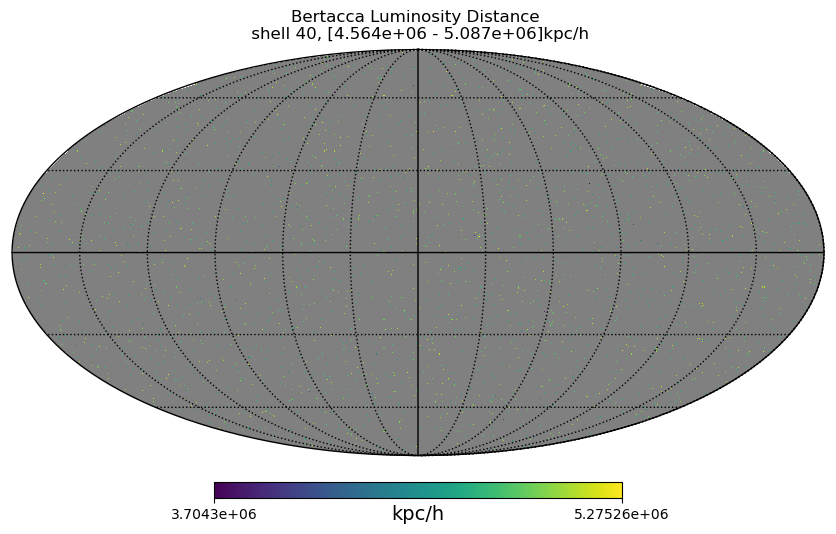

In [10]:
bertacca_map = catalog_selection.bertacca_map(n_side=n_side)
halos_map = catalog_selection.halos_map(n_side=n_side)

masked_map = hp.ma(bertacca_map)
masked_map.mask = bertacca_map == 0

L_D_s = info.from_snapshot_get(snapshot_number, 'xstart') * (1 + info.from_snapshot_get(snapshot_number, 'zstart'))
L_D_e = info.from_snapshot_get(snapshot_number, 'xend') * (1 + info.from_snapshot_get(snapshot_number, 'zend'))
L_D_s = f"{L_D_s:.3e}"
L_D_e = f"{L_D_e:.3e}"

hp.mollview(masked_map, title=f"Bertacca Luminosity Distance \n shell 40, [{L_D_s} - {L_D_e}]kpc/h", unit="kpc/h")
hp.graticule()
plt.show()

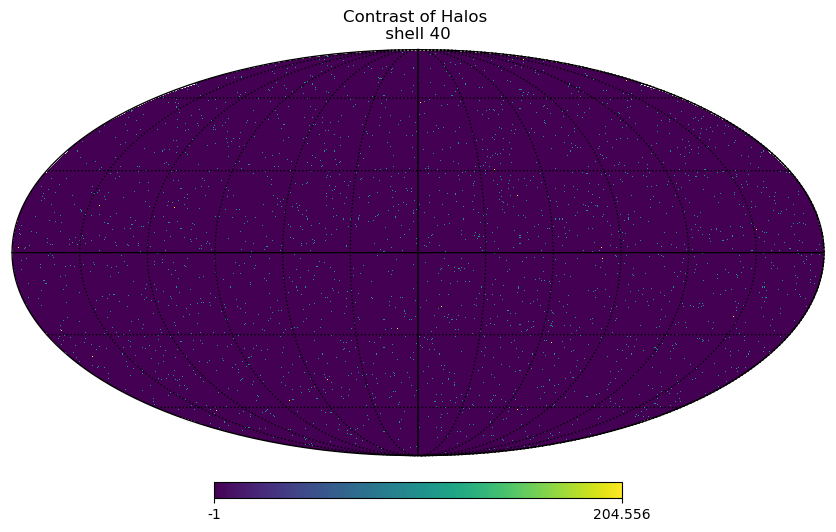

In [11]:
mean_halo_count = np.mean(halos_map)
halo_contrast = (halos_map - mean_halo_count) / mean_halo_count
hp.mollview(halo_contrast, title="Contrast of Halos \n shell 40 ", unit="")
hp.graticule()
plt.show()

## CAMB



In [12]:
nside = 2048  
npix = hp.nside2npix(nside)
snapshot_numbers = range(48, 63)

def lens_weight(z_l, z_s=1100):
    # Cosmological parameters
    OmegaCDM = 0.27  # Dark matter density
    OmegaBr = 0.05  # Baryonic matter density
    OmegaNeu = 0.00  # Neutrino density
    OmegaLambda = 0.68  # Dark energy density
    h_Hubble = 0.67  # Normalized Hubble parameter

    # Initialize the cosmological model
    cosmo = LambdaCDM(H0=h_Hubble * 100, Om0=OmegaCDM + OmegaBr, Ode0=OmegaLambda)

    # Calculate the comoving distance for `z_l`
    d_comov_l = np.array(cosmo.comoving_distance(z_l))

    # If `z_s` is a scalar, calculate directly
    if np.isscalar(z_s):
        if z_s == 0.:
            return 0.  # Return 0 if `z_s` is zero
        d_comov_s = np.array(cosmo.comoving_distance(z_s))
        return (d_comov_s - d_comov_l) / d_comov_s

    # If `z_s` is an array, calculate element by element
    d_comov_s = np.array(cosmo.comoving_distance(z_s))

    # Calculate the lens weight with handling for elements in `z_s` equal to 0
    np.seterr(invalid='ignore')
    lens_weights = np.where(np.isclose(d_comov_s, 0.), 0., (d_comov_s - d_comov_l) / d_comov_s)

    return lens_weights


In [13]:
mass_inf = 0

halo_map = np.zeros(npix)
z_shell = []
halos_number = []
halos_redshift = []
diff = []
for snapshot in snapshot_numbers:
    print(f"Snapshot n: {snapshot}")
    catalog = Catalog(snapshot)
    print(f"Numer of halos: {catalog.get_n_halos()}")
    catalog_selection = catalog.select_mass_above(mass_inf)
    print(f"Number of halos (M>{mass_inf}): {catalog_selection.get_n_halos()} \n")
    del catalog
    
    catalog_selection.compute_pixel(nside)
    halo_map[catalog_selection.pixel] += 1

    catalog_selection.compute_redshift()
    halos_redshift.append(catalog_selection.halos_redshift)
    
    z_shell.append(catalog_selection.redshift)
    halos_number.append(catalog_selection.get_n_halos())
    diff.append(catalog_selection.z_end - catalog_selection.z_start)

halos_redshift = np.concatenate(halos_redshift)

bin_edges = np.linspace(0, 0.485510, 41)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Centri dei bin
halo_counts, _ = np.histogram(halos_redshift, bins=bin_edges)  

# Normalizza
bin_widths = np.diff(bin_edges)
halos_density = halo_counts / bin_widths

Snapshot n: 48
Reading AllSkyMock_snap_048_0.bin0...
Reading AllSkyMock_snap_048_1.bin0...
Reading AllSkyMock_snap_048_2.bin0...
Reading AllSkyMock_snap_048_3.bin0...
Numer of halos: 4400733
Number of halos (M>0): 4400733 

Snapshot n: 49
Reading AllSkyMock_snap_049_0.bin0...
Reading AllSkyMock_snap_049_1.bin0...
Reading AllSkyMock_snap_049_2.bin0...
Reading AllSkyMock_snap_049_3.bin0...
Numer of halos: 3656099
Number of halos (M>0): 3656099 

Snapshot n: 50
Reading AllSkyMock_snap_050_0.bin0...
Reading AllSkyMock_snap_050_1.bin0...
Reading AllSkyMock_snap_050_2.bin0...
Reading AllSkyMock_snap_050_3.bin0...
Numer of halos: 2272139
Number of halos (M>0): 2272139 

Snapshot n: 51
Reading AllSkyMock_snap_051_0.bin0...
Reading AllSkyMock_snap_051_1.bin0...
Reading AllSkyMock_snap_051_2.bin0...
Reading AllSkyMock_snap_051_3.bin0...
Numer of halos: 1898259
Number of halos (M>0): 1898259 

Snapshot n: 52
Reading AllSkyMock_snap_052_0.bin0...
Reading AllSkyMock_snap_052_1.bin0...
Reading AllSk

In [14]:
cmb_map_sum = np.zeros(npix)
for snapshot in snapshot_numbers:
    
    map_file = f'KappaMap_snap_{snapshot:03d}.DM.seed_100672.fits'
    print(f"Reading {map_file}")
    
    z_l = cosmo.from_snapshot_get(snapshot, 'z')
    cmb_weight = cosmo.from_snapshot_get(snapshot, 'cmb_weight')
    cmb_map = lens_weight(z_l, 0.485510) * (1/cmb_weight) * hp.read_map(map_file)
    
    cmb_map_downgraded = hp.ud_grade(cmb_map, nside)
    cmb_map_sum += cmb_map_downgraded


Reading KappaMap_snap_048.DM.seed_100672.fits
Reading KappaMap_snap_049.DM.seed_100672.fits
Reading KappaMap_snap_050.DM.seed_100672.fits
Reading KappaMap_snap_051.DM.seed_100672.fits
Reading KappaMap_snap_052.DM.seed_100672.fits
Reading KappaMap_snap_053.DM.seed_100672.fits
Reading KappaMap_snap_054.DM.seed_100672.fits
Reading KappaMap_snap_055.DM.seed_100672.fits
Reading KappaMap_snap_056.DM.seed_100672.fits
Reading KappaMap_snap_057.DM.seed_100672.fits
Reading KappaMap_snap_058.DM.seed_100672.fits
Reading KappaMap_snap_059.DM.seed_100672.fits
Reading KappaMap_snap_060.DM.seed_100672.fits
Reading KappaMap_snap_061.DM.seed_100672.fits
Reading KappaMap_snap_062.DM.seed_100672.fits


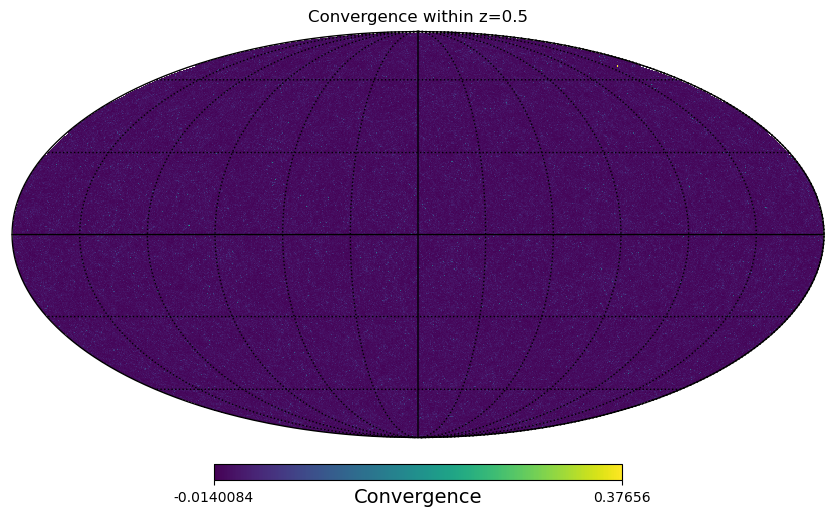

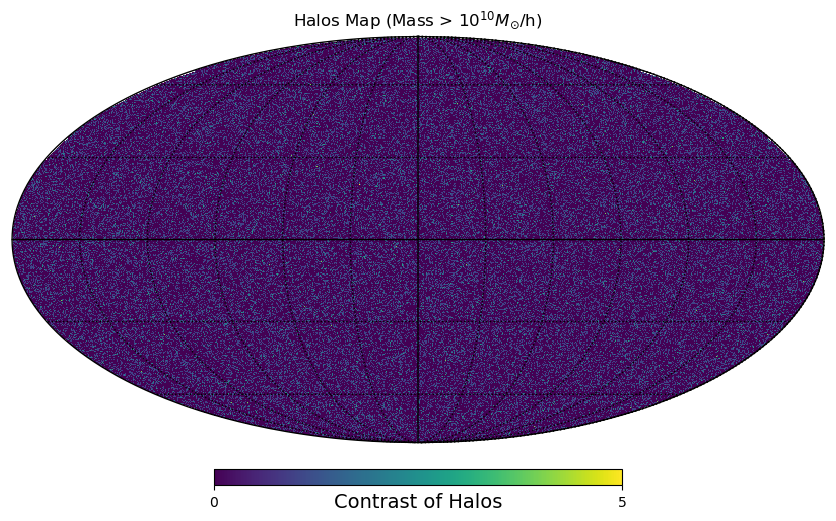

In [15]:
hp.mollview(cmb_map_sum, title="Convergence within z=0.5", unit="Convergence")
hp.graticule()
plt.show()

# Display the halo map
hp.mollview(halo_map, title=r'Halos Map (Mass > $10^{10} M_{\odot}$/h)', unit='Contrast of Halos')
hp.graticule()
plt.show()

In [16]:
#------------------ CROSS CORRELATION ----------------------
mean_halo_count = np.mean(halo_map)
halo_contrast = (halo_map - mean_halo_count) / mean_halo_count
cross_correlation_kappa = hp.anafast(halo_contrast, cmb_map_sum, lmax=3500)

In [17]:
# Simulation
OmegaCDM = 0.27
OmegaBr = 0.05
OmegaNeu = 0.00
OmegaLambda = 0.68
h_Hubble = 0.67
OmegaR0 = 9.2865e-5  # Densità di radiazione
Omega0 = OmegaCDM + OmegaBr  # Densità totale della materia
H0 = h_Hubble * 100  # km/s/Mpc

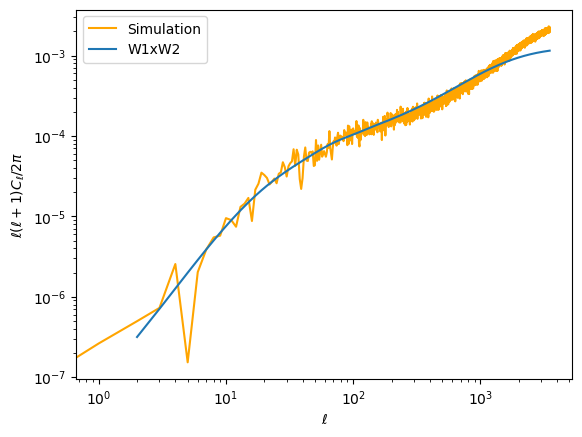

In [18]:
#Get angular power spectrum for galaxy number counts and lensing
import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb import model, initialpower



lmax=3500
pars = camb.CAMBparams()
pars.set_cosmology(H0=67, ombh2=OmegaBr * h_Hubble ** 2, omch2= OmegaCDM * h_Hubble ** 2)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both

#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    SplinedSourceWindow(z = bin_centers, W = halos_density, source_type='counts'),
    GaussianSourceWindow(redshift=0.485510, source_type='lensing', sigma=1e-5)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

#Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
#lensing window functions are for kappa (and counts for the fractional angular number density)
l = np.arange(len(cross_correlation_kappa))
plt.plot(l, cross_correlation_kappa * l * (l + 1)/(2 * np.pi), label='Simulation', color='orange')

ls=  np.arange(2, lmax+1)
plt.loglog(ls, cls['W1xW2'][2:lmax+1], label="W1xW2")

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();
plt.show()